# Predicting Mood Level
---

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [3]:
# List numeric columns
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "sleep_hours",
    "anxiety_level"
]

# List categorical columns
categorical_features = ["gender", "platform", "mental_state"]

# List all features
features = numeric_features + categorical_features

# List target variable
target = "mood_level"

# Select features and target variable
data = df[features + [target]].copy()

---
## Train/Test split the data

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42
)

---
## Build the pipeline

In [5]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])

---
## Fit pipeline

In [6]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
## Evaluate the results

In [7]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.17802469185749545
RMSE: 0.22345744694126923
R²: 0.9175713250076181


MAE ≈ 0.18 - On average, the model is off by 0.18 points on a 1–10 mood scale so is very accurate.

RMSE ≈ 0.22 - Most predictions are within + or - 0.22 points, which is excellent.

R² ≈ 0.918 - The model explains about 92% of the variance in mood.


Create scatter chart to compare actaul with predicted:

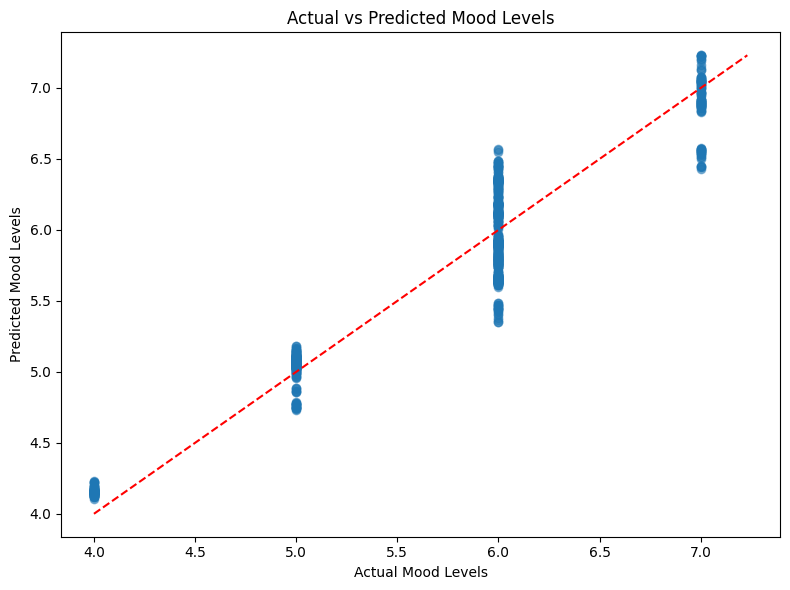

In [8]:
fig = plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted mood levels
plt.scatter(y_test, y_pred, alpha=0.5)

# Add labels and title
plt.xlabel("Actual Mood Levels")
plt.ylabel("Predicted Mood Levels")
plt.title("Actual vs Predicted Mood Levels")

# Add a diagonal line for reference
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")

# Show and save the plot
plt.tight_layout()
plt.savefig('../charts/predicting_mood_level_linear_regression_scatter.png')
plt.show()

What the plot shows:
- Clusters align very closely with the diagonal line, showing strong predictive accuracy.
- There is slightly more vertical spread than in the stress model.
- There is no obvious curvature or bias, predictions rise linearly.


Add a residual chart:

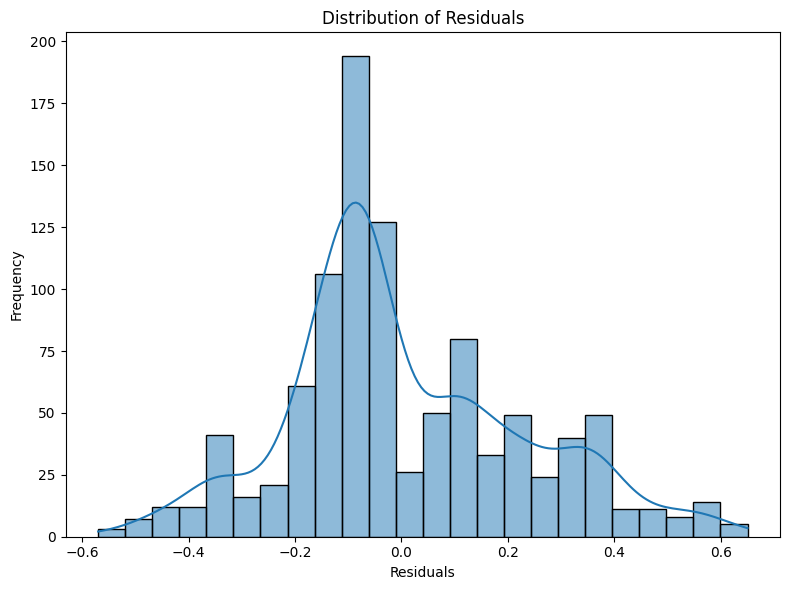

In [9]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))

# Histogram of residuals
sns.histplot(residuals, kde=True)

# Add labels and title
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()

# Show and save the plot
plt.savefig('../charts/predicting_mood_level_linear_regression_residuals.png')
plt.show()

The residuals show small, balanced errors with mild skewness, which is expected because mood is a more subjective and variable outcome than sleep or stress.

---
## Save the model

In [10]:
# save the model
joblib.dump(pipeline, '../models/predicting_mood_level_linear_regression_model.pkl')

['../models/predicting_mood_level_linear_regression_model.pkl']

---
## Run the model on unseen data

I am going to use the persona data created on the cluster notebook to make test predictions.

In [11]:
# laod the persona data
cluster_profiles = pd.read_parquet("../data/cluster_profiles.parquet")

# Prepare input data for prediction
persona_input = cluster_profiles.drop(columns=["mood_level"])

# Make predictions for each persona
preds = pipeline.predict(persona_input)

# Combine predictions with cluster profiles
results = cluster_profiles.copy()
results["model_prediction"] = preds

# Display the results
results

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state,model_prediction
cluster,,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed,6.172503
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed,5.703099
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed,5.257897
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed,5.237605
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy,6.960256
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed,6.022174
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed,4.469907


View just the mood level columns:

In [12]:
# display just mood level and model prediction
results[["mood_level", "model_prediction"]]

,mood_level,model_prediction
cluster,,
0,6.202797,6.172503
1,5.747436,5.703099
2,5.325581,5.257897
3,5.240240,5.237605
4,7.000000,6.960256
5,5.989523,6.022174
6,4.487085,4.469907


The model clearly understands the mood patterns across your persona groups. 

Every predicted value is only a few hundredths away from the actual cluster averages, which fits perfectly with your strong R² score.

Higher mood clusters are recognised as such, and the lower mood group is also predicted very accurately. This suggests that features, like stress, anxiety, sleep, and screen activity, provide enough signal for the model to reliably estimate mood from behaviour patterns.

---
## Conclusion

The mood prediction model performed very well. With an R² of roughly 0.92, it explains most of the variation in mood using behavioural and lifestyle features like stress, anxiety, screen time, and physical activity. 

The residuals are centred nicely around zero and look reasonably normal, which tells us the model isn’t systematically biased in any direction.

The scatter plot shows a tight, linear relationship between actual and predicted values, meaning the model is consistently getting the right idea across all mood levels, from low to high. 

When I tested it on the cluster personas, it predicted each group's mood almost perfectly, usually within just a few hundredths of a point.

Overall, the model seems reliable, stable, and well-calibrated. It captures the general patterns that drive mood in this dataset and produces predictions that make sense both statistically and practically.